In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import os
import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.signal import lfilter
from scipy import signal

## **Data**

Reference

<br>


Librispeech: test-clean

Github: https://raw.githubusercontent.com/hsnam95/class2023Fall/main/aeiou.wav

In [ ]:
# load data
data = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

### Librispeech data

Understanding Data Characteristics

In [ ]:
sample = data[0]
s1 = sample[0]
s1 = s1.numpy()
sr1 = sample[1]

In [ ]:
# data
print(len(data))
print(data[0])

2620

In [ ]:
print(len(s1))
print(s1.shape)

166960
(166960,)


### **Experiment 1**: Listen to Real Sounds!

In [ ]:
s1 = s1.squeeze() #(1,166960) -> (166960,)
s1 = librosa.util.normalize(s1)
ipd.Audio(s1[100000:300000], rate=sr1)

#### Github: "https://raw.githubusercontent.com/hsnam95/class2023Fall/main/aeiou.wav"

Understanding Data Characteristics

In [ ]:
url = "https://raw.githubusercontent.com/hsnam95/class2023Fall/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')

In [ ]:
print(len(s))
print(s.shape)

48600
(48600,)


### **Experiment 2**: Listen to Real Sounds!

In [ ]:
s = librosa.util.normalize(s)
ipd.Audio(s[0:48000], rate=sr)

## **Audio Processing(Digital signal processing: Simple examples)**

### RMS(Root Mean Square) for intensity

Calculate the RMS energy for each frame of the audio.

RMS energy is a metric for measuring the intensity or energy of a signal, and it is useful for capturing the **dynamic variations** in a speech signal.

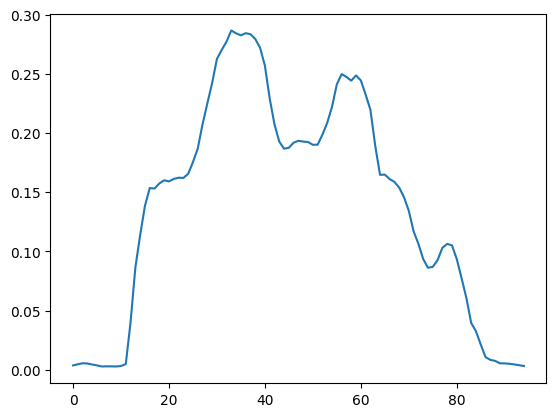

In [ ]:
rms = librosa.feature.rms(y=s)
plt.plot(rms[0])

### Autocorrelation for pitch(F0) measurement

The process of estimating the fundamental frequency (F0: the pitch of the sound) of the audio signal "s".

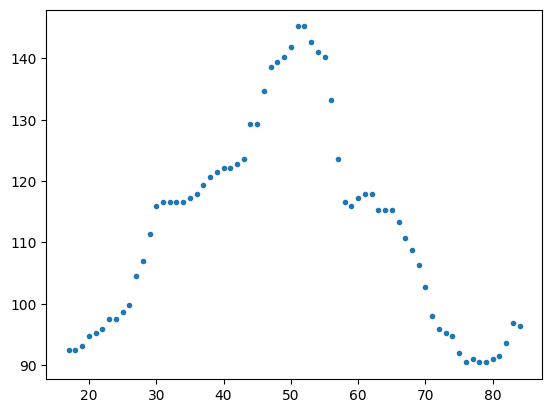

In [ ]:
F0, voiced_flag, voiced_prob = librosa.pyin(s, fmin=60, fmax=200)
plt.plot(F0, '.')

## **Audio Processing(Digital signal processing: Analyze)**

### **Sampling**

Analog information must be represented as discrete digital information. At this time, we discretely partition analog information based on certain criteria.

<br>

**Time domain**

The analog signal is partitioned based on time. Through sampling, the computer receives the sound sequence as binary values.

<br>


__Sampling rate__<br>

The finer the partitioning, the more similar it is to the original data, but the amount of data increases.
If it is partitioned too coarsely, it will become difficult to reconstruct the original data.

<br>


__Sampling theorem__<br>

**Nyquist Sampling Theorem**: The sampling rate must be greater than twice the maximum frequency.

$ f_{s} > 2f_{m} $

Here, $f_{s}$ denotes the sampling rate, and $f_{m}$ denotes the maximum frequency.
- Audio CD : 44.1 kHz(44100 sample/second)
- Speech communication : 8 kHz(8000 sample/second)


### Sampling using Librispeech data


In [ ]:
data[1]

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

In [ ]:
audioData = data[1][0][0]
sr = data[1][1]

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) torch.Size([52400])


In [ ]:
print(audioData, audioData.shape)
print(len(audioData))
# information of duration
print(len(audioData) / sr)

52400

In [ ]:
print(data[0][0].shape)
print(data[1][0][0])


3.275

In [ ]:
ipd.Audio(audioData, rate=sr)


### Resampling

Sampled data can be resampled to a higher or lower sampling rate. In these cases, a low-pass filter is generally used for interpolation (windowed sinc function).

In [ ]:
#tensor -> numpy
y_8k = librosa.resample(audioData.numpy(), orig_sr=sr, target_sr=8000)
ipd.Audio(y_8k, rate=8000)

In [ ]:
len(y_8k)

26200

In [ ]:
y_2k = librosa.resample(audioData.numpy(),orig_sr=sr, target_sr=4000)
ipd.Audio(y_2k, rate=2000)

In [ ]:
len(y_2k)

13100

### Nomalization & Quantization

Instead of using time as a reference, the signal's values are adjusted based on the actual real-valued amplitude. The amplitude is divided into discrete intervals, and the amplitude of the signal data is rounded.

Discrete intervals can be partitioned by bits.

- B-bit Quantization: $-2^{B-1}$ ~ $2^{B-1}-1$
- Audio CD Quantization (16 bits): $-2^{15}$ ~ $2^{15}-1$
- These values are usually scaled to the range of -1.0 ~ 1.0.

In [ ]:
audio_np = audioData.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate=sr)

In [ ]:
#quantization -> light & efficient
Bit = 8
max_value = 2 ** (Bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr)

### mu-law encoding

The human ear responds logarithmically to the amplitude of sound.

Subtle differences in quiet sounds are easily distinguished, but as sounds become louder, these differences become less perceptible. This characteristic is reflected in the representation of wave values, assigning high resolution to small values and low resolution to large values.

In [ ]:
def mu_law(x, mu=255):
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

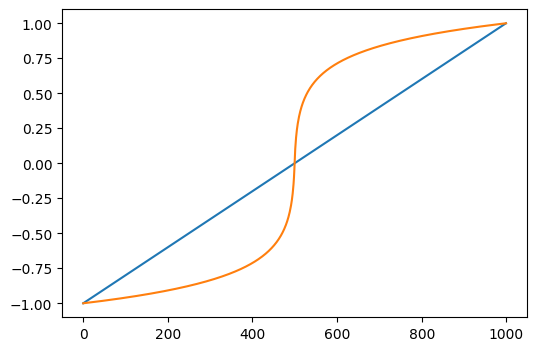

In [ ]:
x = np.linspace(-1, 1, 1000)
x_mu = mu_law(x)

plt.figure(figsize=[6, 4])
plt.plot(x)
plt.plot(x_mu)
plt.show()

In [ ]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)

### **Fourier transform**

The Fourier transform (퓨리에 변환) is a method of representing any arbitrary input signal by decomposing it into a sum of periodic functions (or complex exponential functions) with various frequencies. It is also the process of determining the amplitude (진폭) of each periodic function.

Period: The time or length required for a wave to complete one oscillation; generally, the period of a sine function is given by $2\pi /w$.
Frequency: The number of oscillations that occur in one second.

#### Remind

The formula for the **Fourier transform** is as follows.

$$
y(t)=\sum_{k=-\infty}^\infty A_k \, \exp \left( i\cdot 2\pi\frac{k}{T} t \right)
$$

The formula for the **Amplitude** is as follows.
$$
A_k = \frac{1}{T} \int_{-\frac{T}{2}}^\frac{T}{2} f(t) \, \exp \left( -i\cdot 2\pi \frac{k}{T} t \right) \, dt
$$

**Euler's formula** is given by:

$$
e^{i\theta} = \cos{\theta} + i\sin{\theta}
$$

Substituting Euler's formula into the above equation yields:

$$
\exp \left( i\cdot 2\pi\frac{k}{T} t \right) = \cos\left({2\pi\frac{k}{T}}\right) + i\sin\left({2\pi\frac{k}{T}}\right)
$$


Here, the functions $\cos\left(2\pi\frac{k}{T}\right)$ and $i\sin\left(2\pi\frac{k}{T}\right)$ are periodic functions with specific periods and frequencies.

In other words, **the Fourier transform enables any input signal to be decomposed into a sum of periodic functions such as sin and cos.**


### DFT (Discrete Fourier Transform)

If we extend the Fourier transform equation mentioned above into the discrete domain, it becomes as follows.


If the discrete data we collected, $y_{n}$repeats with a period N, the DFT can be expressed as a sum of
N sine functions with different frequencies and amplitudes.

$$
y_n = \frac{1}{N} \sum_{k=0}^{N-1} Y_k \cdot \exp \left( i\cdot 2\pi\frac{k}{N} n \right)
$$

From the above equation, we can see that the range of
*k* changes from 0 to
*N−1*.

$$
Y_k = \sum_{n=0}^{N-1} y_n\cdot \exp \left( -i\cdot 2\pi\frac{k}{N} n \right)
$$

- $y_{n}$ : input signal
- $n$ : Discrete time index
- $k$ : discrete frequency index
- $Y_{k}$ :  Spectrum value corresponding to the
kth frequency

In [ ]:
def DFT(x):
    N = len(x)
    X = np.array([])
    nv = np.arange(N)

    for k in range(N):
        s = np.exp(1j*2*np.pi*k/N*nv)
        X = np.append(X, sum(x*np.conjugate(s)))
    return X

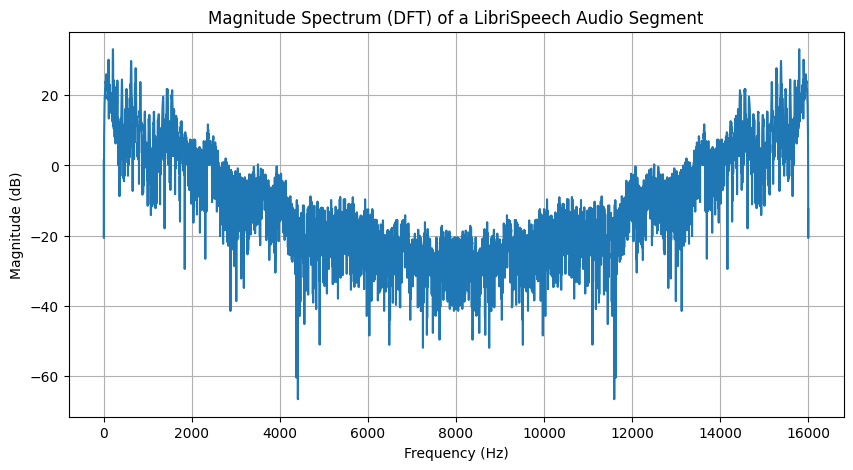

In [ ]:
s2 = data[2]
audio_tensor = s2[0]
if hasattr(audio_tensor, "numpy"):
    audio_np = audio_tensor.numpy()
else:
    audio_np = audio_tensor

if audio_np.ndim == 2:
    audio_np = audio_np[0]

segment = audio_np[:10000]


X = DFT(segment)


sr2 = s2[1]
freq = np.linspace(0, sr2, len(X))


mag = 20 * np.log10(np.abs(X) + 1e-8)

plt.figure(figsize=(10, 5))
plt.plot(freq, mag)
plt.title("Magnitude Spectrum (DFT) of a LibriSpeech Audio Segment")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()

### **STFT (Short-Time Fourier Transform)**

When the frequency of a signal changes over time, the FFT does not indicate at which time the frequency changes. To overcome this limitation, the STFT divides the time length and then performs the Fourier transform. (When performing an FFT, information about the time domain is lost.)

It is a method for analyzing sounds whose frequency characteristics change over time. It is generally suitable for the signal data we use. The time series data is divided into fixed time intervals (window size), and the spectrum is computed for each interval. This is represented as two-dimensional time-frequency data.

$$
X(l,k) = \sum_{n=0}^{N-1} w(n) x(n+lH)\exp^{\frac{-2\pi k n}{N}}
$$

- $N$ : FFT size
    - Determines into how many frequency bands the window is divided

- Duration
    - The value obtained by dividing the window by the sampling rate
    - $T= window/SR$
    - T(Window) = 5T(Signal), meaning the duration is set to be at least 5 times longer than the signal period.

- $w(n)$ : Window function
    - Typically, a Hann window is used.

- $n$ : Window size
    - The number of samples included in the window function.
    - A smaller window size results in low-frequency resolution and high time resolution.
    - A larger window size results in high-frequency resolution and low time resolution.
    
- $H$ : Hop size
    - The amount by which the windows overlap. Generally, about 1/4 overlap is used.

The result of the STFT returns the amplitude in the frequency domain over time (window).

In [ ]:
audioData = data[1][0][0]
sr = data[1][1]

print("="*40)
print(f"샘플링 레이트 (sr): {sr}")
print("="*40)

print("오디오 데이터 (tensor 형태):")
print(audioData)
print("="*40)
print(f"오디오 데이터 shape: {audioData.shape}")

audio_np = audioData.numpy()

print("="*40)
print("오디오 데이터 (numpy 배열 형태):")
print(audio_np)

샘플링 레이트 (sr): 16000
오디오 데이터 (tensor 형태):
tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011])
오디오 데이터 shape: torch.Size([52400])
오디오 데이터 (numpy 배열 형태):
[ 0.0010376   0.00109863  0.00091553 ... -0.0007019  -0.00097656
 -0.00109863]


In [ ]:
# using STFT, audio_np ->  time-frequency
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)

(513, 103) 103 (0.022626022+0j)


In [ ]:
print(S.shape, len(S[0]), S[0][0])
print(S)

array([[ 0.02262602+0.0000000e+00j, -0.05884637+0.0000000e+00j,
        -0.02625498+0.0000000e+00j, ...,  0.04703658+0.0000000e+00j,
        -0.10275772+0.0000000e+00j,  0.08783279+0.0000000e+00j],
       [-0.02681388-1.8120866e-02j,  0.03790738-7.8518270e-03j,
        -0.00889512-9.1458801e-03j, ..., -0.04557749-2.3772500e-01j,
         0.13888891+3.1923160e-01j,  0.04679581-1.2743142e-01j],
       [ 0.06089374+4.4774324e-02j, -0.00690025-3.0232264e-02j,
         0.02921003+1.3654881e-02j, ..., -0.01928553+1.3721973e-01j,
        -0.1489643 -2.5934309e-01j, -0.20659886+2.4182068e-02j],
       ...,
       [-0.00046766+3.3541666e-03j, -0.00134465+2.0302692e-03j,
         0.00111155-1.3944925e-03j, ...,  0.00076722-1.4168157e-03j,
         0.00215575+1.2777701e-03j, -0.00049373+1.5059601e-04j],
       [-0.00252852-2.9581576e-03j, -0.001215  -2.1861666e-03j,
        -0.00376799+3.1128232e-03j, ..., -0.00342117+3.1496247e-03j,
        -0.00530687-2.5308989e-03j, -0.0011173 +1.7242117e-03j]

In [ ]:
# This code is executed to remove the phase information from the STFT result S and to generate a power spectrogram
# that represents the energy of each frequency component.
D = np.abs(S)**2
# compare D with S
print(D.shape)
print(D)

(513, 103)
[[5.1193684e-04 3.4628955e-03 6.8932399e-04 ... 2.2124404e-03
  1.0559149e-02 7.7145984e-03]
 [1.0473497e-03 1.4986208e-03 1.6277027e-04 ... 5.8590494e-02
  1.2119895e-01 1.8428616e-02]
 [5.7127881e-03 9.6160336e-04 1.0396814e-03 ... 1.9201186e-02
  8.9449212e-02 4.3267865e-02]
 ...
 [1.1469139e-05 5.9300896e-06 3.1801526e-06 ... 2.5959896e-06
  6.2799381e-06 2.6644986e-07]
 [1.5144133e-05 6.2555437e-06 2.3887440e-05 ... 2.1624561e-05
  3.4568307e-05 4.2212682e-06]
 [1.6557269e-05 3.0068535e-05 4.4681386e-05 ... 3.8015805e-05
  5.6579658e-05 1.1113687e-05]]


<ipython-input-81-ce2b1181766a>:3: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  log_S = librosa.power_to_db(S, ref=np.max) # To DB


Text(0.5, 1.0, 'Spectrogram')

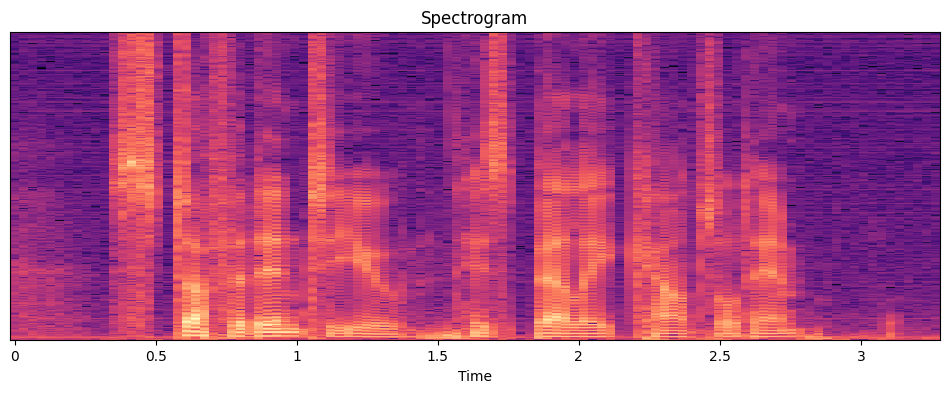

In [ ]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
D = np.abs(S)**2
log_S = librosa.power_to_db(S, ref=np.max) # To DB

# visualization
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=16000, x_axis='time')
plt.title('Spectrogram')

### Window function

Window functions and window sizes are used in specific situations, and their purposes are clearly defined. The primary function of a window function is to control the trade-off between the width of the main lobe and the level of the side lobes. Additionally, a window function serves to mitigate the Gibbs phenomenon.

#### **Gibb's phenomenon**

Gibbs phenomenon refers to the peculiar behavior observed when approximating discontinuous functions (e.g., square waves) using Fourier series!

It can be observed that even when the number of terms is increased, the overshoot near the discontinuities remains at approximately 9%.

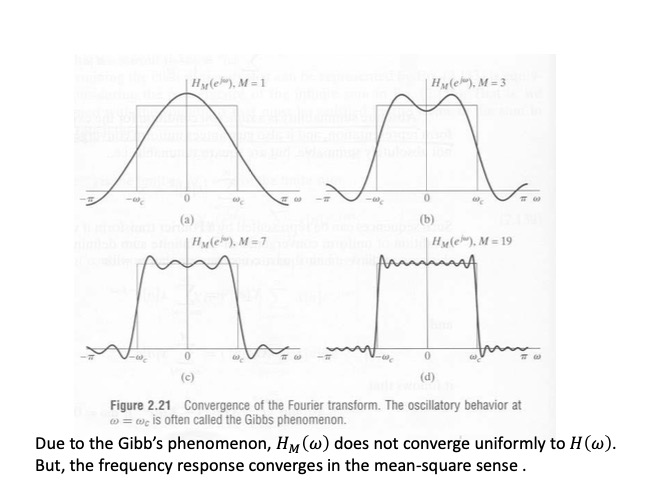

#### **Gibb's phenomenon simple visualization**

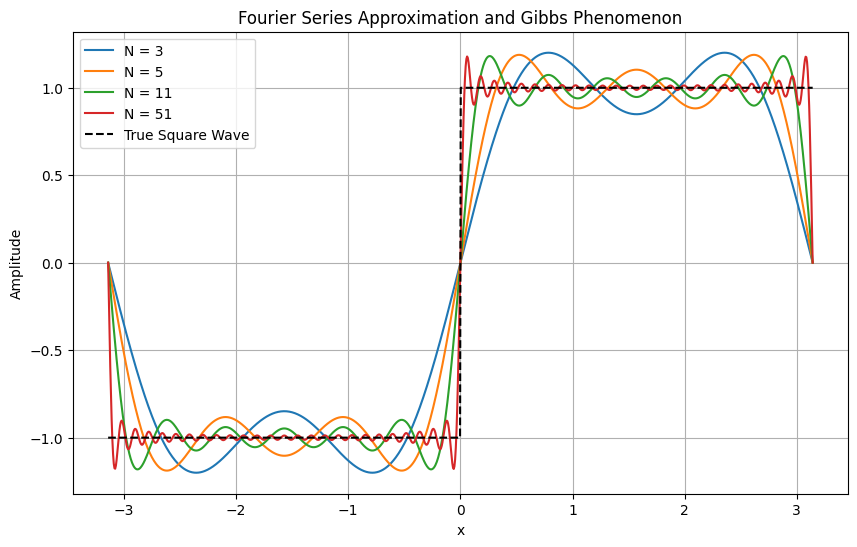

In [ ]:
def square_wave_fourier(x, N):
    y = np.zeros_like(x)
    for n in range(1, N+1, 2):
        y += (4 / (np.pi * n)) * np.sin(n * x)
    return y

# Range x : -pi ~ pi, discontinuity at x= -pi, 0, pi
x = np.linspace(-np.pi, np.pi, 1000)
true_square = np.sign(x)

plt.figure(figsize=(10,6))
for N in [3, 5, 11, 51]:
    y = square_wave_fourier(x, N)
    plt.plot(x, y, label=f'N = {N}')

plt.plot(x, true_square, 'k--', label='True Square Wave')
plt.title("Fourier Series Approximation and Gibbs Phenomenon")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def frame_audio(audio, FFT_size=1024, hop_size=20, sample_rate = 22050):
    audio = np.pad(audio, int(FFT_size/2), mode='reflect')
    frame_len = np.round(sample_rate*hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))

    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    return frames

audio_framed = frame_audio(audio_np)
print("Framed audio shape: {}".format(audio_framed.shape))

Framed audio shape: (119, 1024)


#### Window function

By applying the Hann window, the discontinuities at the frame boundaries are reduced, thereby mitigating the Gibbs phenomenon.

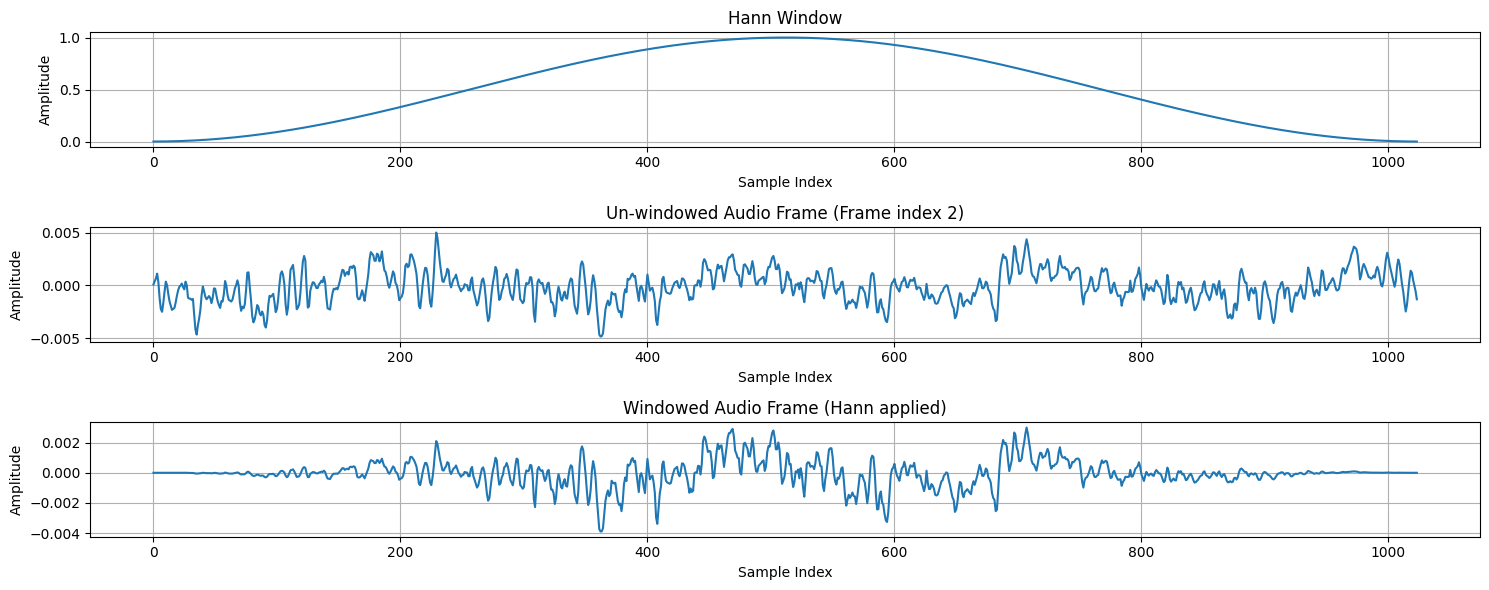

In [ ]:
window = signal.get_window("hann", 1024, fftbins=True)
audio_win = audio_framed * window
ind = 2

plt.figure(figsize=(15,6))

# 1. Hann Window 시각화
plt.subplot(3,1,1)
plt.plot(window)
plt.title("Hann Window")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

# 2. 원본 (Un-windowed) Audio Frame 시각화
plt.subplot(3,1,2)
plt.plot(audio_framed[ind])
plt.title("Un-windowed Audio Frame (Frame index {})".format(ind))
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

# 3. 윈도우 적용 (Windowed) Audio Frame 시각화
plt.subplot(3,1,3)
plt.plot(audio_win[ind])
plt.title("Windowed Audio Frame (Hann applied)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

If you look at the plot, you'll notice that before applying windowing, the endpoints of the plot vary, but after windowing, the resulting plot consistently reaches 0 at the ends.

##### Window size

Window size generally controls the resolutions of time and frequency.

- Short window: provides low frequency resolution and high time resolution.
- Long window: provides high frequency resolution and low time resolution.

### Sound Representation

Discrete data sampled as above can be transformed into a representable form.

The first method is the **Time-domain Representation**, where the audio is viewed as the magnitude of air waves over time.

The second method is the **Time-Frequency Representation**, which observes the changes in frequency over time.

#### Time domain - Waveform
In the case of the waveform, it is a natural representation of audio. Time is represented on the x-axis, and amplitude is represented on the y-axis.

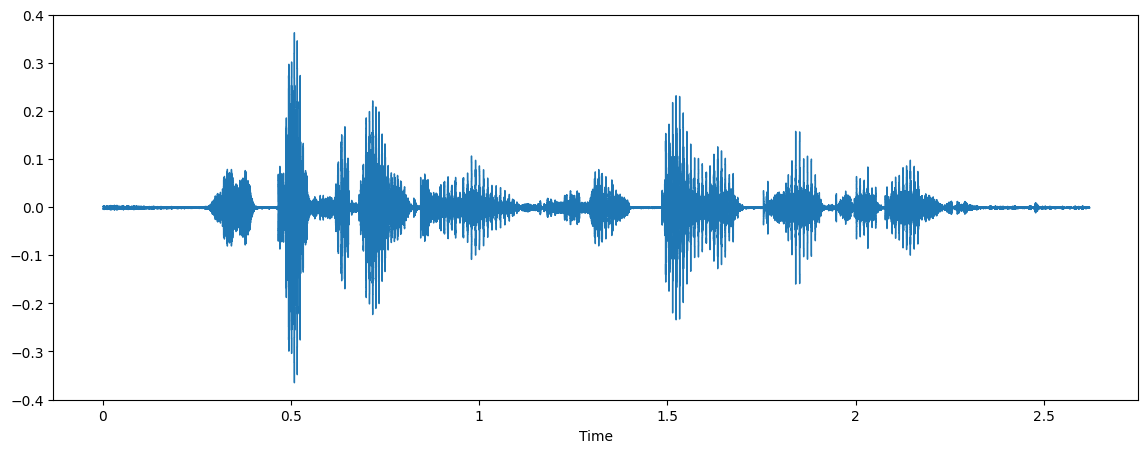

In [ ]:
audio_np = audioData.numpy()  # convert numpy array

fig = plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_np[0:100000], sr=sr)

#### Time-frequency representation

Time-frequency representation is a method of analyzing an audio signal simultaneously in both the time and frequency domains. Time is represented on the x-axis, frequency on the y-axis, and amplitude or power is depicted by colors or brightness.

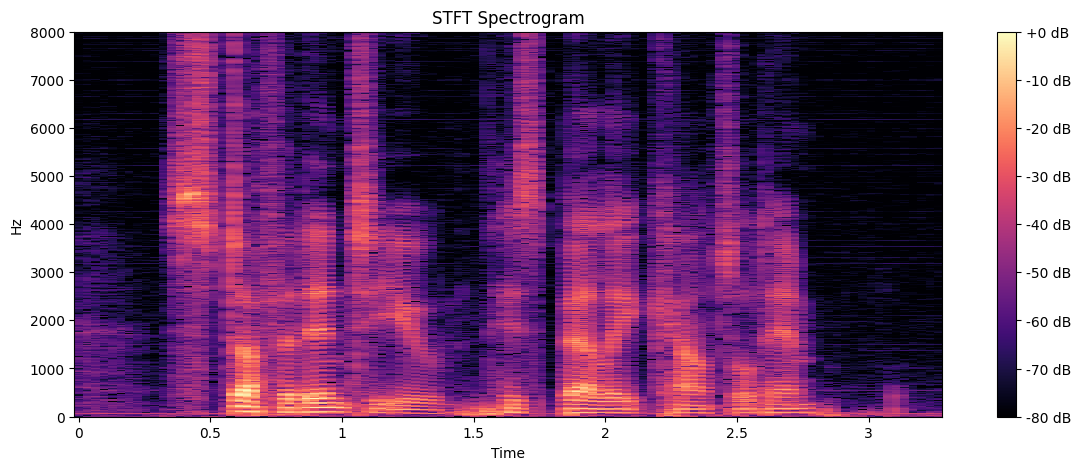

In [ ]:
# STFT
D = librosa.stft(audio_np)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.show()

## **Speech Processing**
> pulse train (=source), vocal tract (=filter), Formants, LPC coeffiencts, Spectrum

### **Generate pulse train (=source at larynx)**

Using simple sine waves to generate signals

#### Sinusoidal Signal Synthesis
All signals can be represented as a combination of sinusoidal signals with different frequencies, magnitudes, and phases.
(Remember that the Fourier transform is a method for separating out the individual sine waves that compose a composite sinusoidal signal!)

#### **Experiment 1**: Generating a Pulse Train Using a Single Sine Wave

Try generating the signal by varying the parameters!

In [ ]:
def phasor_sine(amp, sr, dur, freq, phase):
  t = np.arange(1, sr * dur+1)/sr
  theta = t * 2*np.pi * freq + phase
  s = amp * np.sin(theta)
  return s, t, theta

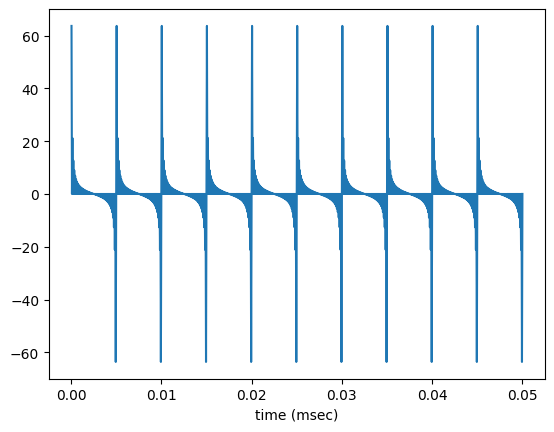

In [ ]:
# parameter setting
# amplitude
amp = 2
# sampling frequency
sr = 20000
# duration
dur = 0.5
# frequency
F0 = 200
# applying Nyquist sampling theorem
Fend = int(sr/2)
# initial phase
phase = 0
s_all = 0

for freq in range(F0, Fend+1, F0):
  s, t, theta = phasor_sine(amp, sr, dur, freq, phase)
  s_all += s

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s_all[0:1000]);
ax.set_xlabel('time (msec)')
ipd.Audio(s_all, rate=sr)

#### **Experiment 2:** Formant-based Speech Signal Synthesis

The table below indicates that F1, F2, F3, F4, and F5 represent the characteristic formant frequencies for each vowel (/a/, /e/, /i/, /o/, /u/).

Let's generate a signal by referring to the table.

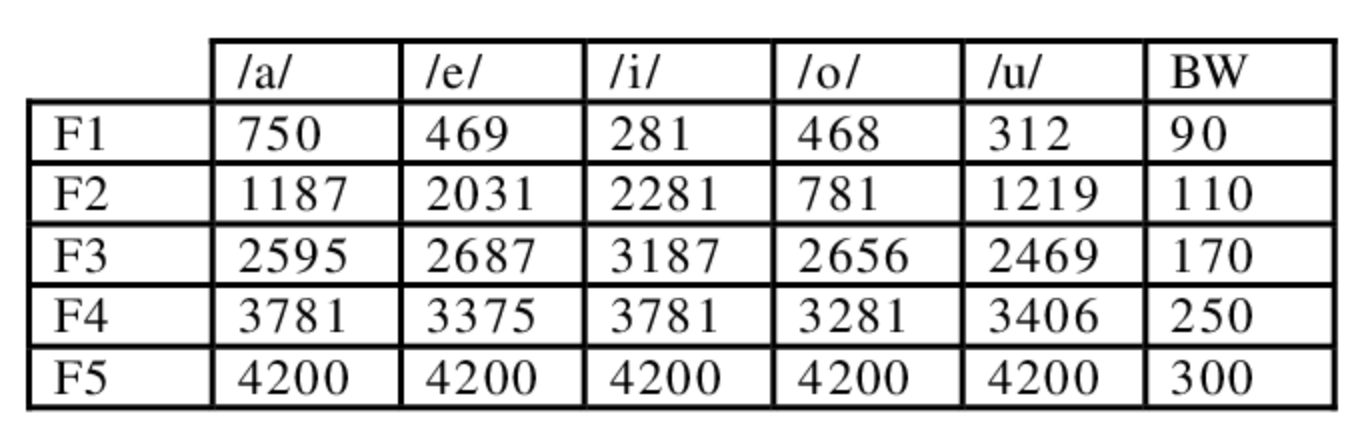

In [ ]:
def hz2w(F, sr):
    NyFreq = sr/2;
    w = F/NyFreq *np.pi;
    return w

def resonance (srate, F, BW):
    a2 = np.exp(-hz2w(BW,srate))
    omega = F*2*np.pi/srate
    a1 = -2*np.sqrt(a2)*np.cos(omega)
    a = np.array([1, a1, a2])
    b = np.array([sum(a)])
    return a, b

In [ ]:
s = s_all

In [ ]:
RG = 0  # RG는 Glottal Resonator의 frequency
BWG = 100  # BWG는 Glottal Resonator의 bandwidth
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 281  # RG: first Formant frequency
BWG = 90  # BWG: first Formant bandwidth
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 2281  # RG: second Formant frequency
BWG = 110  # BWG: second Formant bandwidth
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 3187  # RG: third Formant frequency
BWG = 170  # BWG: third Formant bandwidth
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 3781
BWG = 250
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 4200
BWG = 300
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
s = lfilter(np.array([1, -1]), np.array([1]), s)
ipd.Audio(s, rate=sr)

#### **Experiment 3**: Timbre and Scale Generation through Multi-Sinusoidal Synthesis

The process of generating a complex signal by summing sinusoidal waves with different frequencies, amplitudes, and phases.

In [ ]:
A = 0.9
f = 340
phi = np.pi/2
fs = 22050
t = 1

In [ ]:
def Sinusoid(A,f,phi,fs,t):
    t = np.arange(0,t,1.0/fs)
    x = A * np.cos(2*np.pi*f*t+phi)
    return x

In [ ]:
sin2 = Sinusoid(A,f,phi,fs,t)

In [ ]:
A2 = 0.5
f2 = 110
phi2 = 0.0
sin = Sinusoid(A2, f2, phi2, fs, t)

In [ ]:
complexwave = sin  + sin2

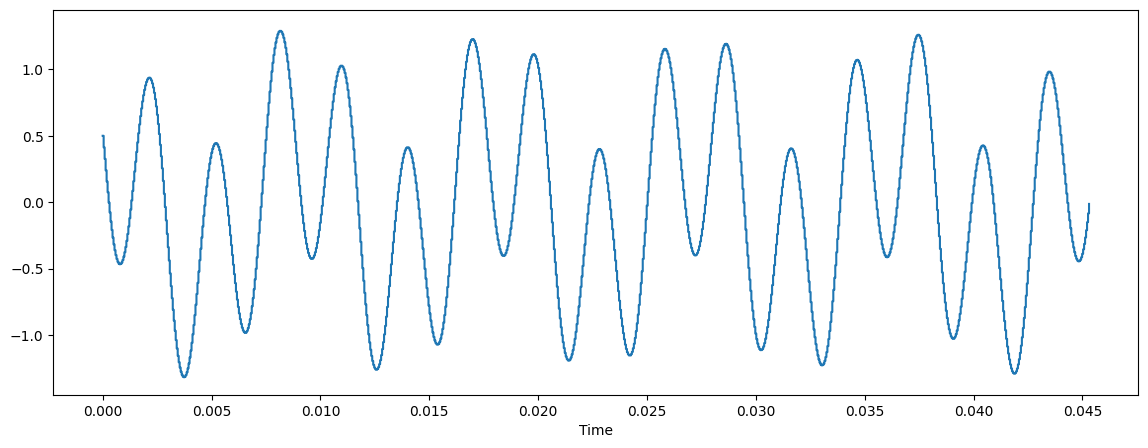

In [ ]:
fig = plt.figure(figsize = (14,5))
librosa.display.waveshow(complexwave[:1000], sr=fs)
ipd.Audio(sin + sin/2 + sin/4, rate=fs)

In [ ]:
def generate_sinusoid_scale(pitches=[69], duration=0.5, Fs=22050, amplitude_max = 0.5):
    N = int(duration * Fs)
    t = np.arange(N) / Fs
    x = []
    for p in pitches:
        omega = 2 ** (( p - 69 ) / 12 ) * 440
        x = np.append(x, np.sin(2 * np.pi * omega * t))
    x = amplitude_max * x/np.max(x)
    return x

duration = 1
Fs = 22050

pitches = [36,48,60,72,84,96]
x = generate_sinusoid_scale(pitches=pitches, duration=duration, Fs=Fs)
print('Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}', flush=True)
ipd.display(ipd.Audio(data=x, rate=Fs))

Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}



# Reference

- Digital Signal Processing Lecture
https://github.com/spatialaudio/digital-signal-processing-lecture

- Python for Signal Processing (unipingco)
https://github.com/unpingco/Python-for-Signal-Processing

- Audio for Deep Learning (남기현님)
https://tykimos.github.io/2019/07/04/ISS_2nd_Deep_Learning_Conference_All_Together/

- 오디오 전처리 작업을 위한 연습 (박수철님)
https://github.com/scpark20/audio-preprocessing-practice

- Musical Applications of Machine Learning
https://mac.kaist.ac.kr/~juhan/gct634/

- Awesome audio study materials for Korean (최근우님)
https://github.com/keunwoochoi/awesome-audio-study-materials-for-korean

- Digital Signal Processing Lecture(colab): https://colab.research.google.com/drive/1wdHc0sy3ECw-R48BvJvsB6w8o-nK7Nfp?usp=sharing